In [1]:
import pandas as pd, numpy as np
import io
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt

# load the dataset
facts = pd.read_csv("rst_transitions.tab",sep="\t",quoting=3)

facts.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28378 entries, 0 to 28377
Data columns (total 32 columns):
First-Queue                 28378 non-null object
First-QueueDist-To-Begin    28378 non-null object
First-QueueEduFunc          28378 non-null object
First-QueueFullFunc         28378 non-null object
First-QueueFullPos          28378 non-null object
Queue                       28378 non-null object
SeqPredFirstSpan            28378 non-null object
SeqPredTop1Span             28378 non-null object
Stack                       28378 non-null object
Stack-QueueDir              28378 non-null object
Stack-QueueSType            28378 non-null object
Stack-QueueSameSent         28378 non-null object
Stack-QueueXML              28378 non-null object
Top1-Stack                  28378 non-null object
Top1-StackDist-To-Begin     28378 non-null object
Top1-StackDist-To-End       28378 non-null object
Top1-StackLength-EDU        28378 non-null object
Top1-StacknEDUs             28378 non-nul

In [2]:
# Some numerical columns are object because they contain missing values
# You may want to convert them to numerical and fille NAs somehow
num_with_missing = ['First-QueueDist-To-Begin','Top2-StackDist-To-End','Top2-StackLength-EDU',
				'Top1-StackLength-EDU','Top1-StacknEDUs']

for col in num_with_missing:
	facts[col] = pd.to_numeric(facts[col],errors="coerce").fillna(value=-1)

In [3]:
# Depending on the approach you take you may want to handle rare values 
# which might be absent from test

for col in ['Top12-StackSType','Stack-QueueSType']:
	facts.loc[facts[col].value_counts()[facts[col]].values < 20, col] = "_"

# The following relations should be impossible
#facts = facts[~facts['label'].isin(["restatement-SN","sequence-NS","span-NS","elaboration-SN"])]
#facts.reset_index(drop=True, inplace=True)

# Shuffle the data
facts = facts.sample(frac=1,random_state=42)



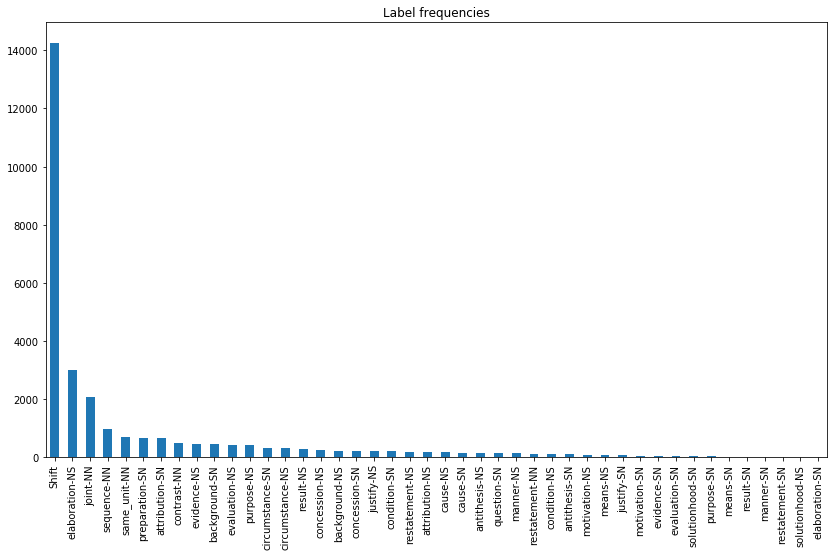

Data shape: (28378, 32)
44 labels


,First-Queue,First-QueueDist-To-Begin,First-QueueEduFunc,First-QueueFullFunc,First-QueueFullPos,Queue,SeqPredFirstSpan,SeqPredTop1Span,Stack,Stack-QueueDir,...,Top1Span,Top1SpanEduFunc,Top1SpanFullFunc,Top1SpanFullPos,Top2-Stack,Top2-StackDist-To-Begin,Top2-StackDist-To-End,Top2-StackLength-EDU,genre,label
28139,"# Many people choose to leave out the green , #",30.0,root,# amod nsubj root mark xcomp compound:prt det ...,"# JJ NNS VBP TO VB RP DT NN , #",NonEmpty,elabo,elabo,MoreElem,LEFT_NONE,...,# that you want to flavor the vodka with . #,acl:relcl,# obl nsubj acl:relcl mark xcomp det obj case ...,# WDT PRP VBP TO VB DT NN IN . #,# Separate the colors of Skittles #,28,118.0,1.0,whow,elaboration-NS
11427,# and police were called in and so on . #,128.0,conj,# cc nsubj:pass aux:pass conj compound:prt cc ...,# CC NNS VBD VBN RP CC RB RB . #,NonEmpty,list,elabo,MoreElem,NONE,...,"# So that ’s a frightening idea , #",root,# advmod nsubj cop det amod root punct #,"# RB DT VBZ DT JJ NN , #",# Sit down strikes # which began at a signific...,119,10.0,8.0,interview,evaluation-NS
2325,# Replication in Second Language Research : #,1.0,root,# root case amod compound nmod punct #,# NN IN JJ NN NN : #,NonEmpty,elabo,None,Empty,None,...,None,None,None,None,None,None,-1.0,-1.0,academic,Shift
27090,# nevertheless this is a small price to pay fo...,35.0,root,# advmod nsubj cop det amod obj mark root case...,# RB DT VBZ DT JJ NN TO VB IN PRP$ NN . #,NonEmpty,elabo,elabo,MoreElem,NONE_NONE,...,# It is likely that the shock will dislocate o...,root,# nsubj cop root mark det nsubj aux ccomp cc c...,# PRP VBZ JJ IN DT NN MD VB CC VB DT PRP$ NNS : #,# The G-forces will multiply your body weight ...,31,71.0,3.0,whow,Shift
21040,# Socializing can help you get more out of you...,169.0,root,# nsubj aux root iobj xcomp obj case fixed nmo...,"# VBG MD VB PRP VB RBR IN IN PRP$ NN , VB NNS ...",NonEmpty,list,contr,MoreElem,LEFT_NONE,...,# but there is a lot more #,conj,# cc expl conj det nsubj amod #,# CC EX VBZ DT NN JJR #,# I went into my program # thinking of the deg...,164,14.0,2.0,reddit,Shift


In [4]:
facts["label"].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Label frequencies")
plt.xticks(rotation='vertical')
plt.show()

print("Data shape: " + str(facts.shape))
print(str(len(facts["label"].value_counts())) + " labels")
facts.head()


### Feature 1 & 2: connectives + head features

In [5]:
import pickle

# If you want to engineer some table features
# before creating a dev partition, this is the place!
facts["First-Queue-Len"] = facts["First-Queue"].str.len()

def find_conn(df):
    conn_dict = {line.strip().split('\t')[0]: int(line.strip().split('\t')[1])
                 for line in open('pdtb_conn.tab').readlines() if int(line.strip().split('\t')[1]) > 1}

    if_conn_first_queue = []
    conn_freq_first_queue = []
    if_conn_top1_span = []
    conn_freq_top1_span = []

    for index, row in df.iterrows():
        first_queue = row['First-Queue']
        top1_span = row['Top1Span']
        for conn in conn_dict.keys():
            if conn in first_queue:
                if_conn_first_queue.append(True)
                conn_freq_first_queue.append(conn_dict[conn])
            else:
                if_conn_first_queue.append(False)
                conn_freq_first_queue.append(0)
            if conn in top1_span:
                if_conn_top1_span.append(True)
                conn_freq_top1_span.append(conn_dict[conn])
            else:
                if_conn_top1_span.append(False)
                conn_freq_top1_span.append(0)

    df['if_conn_first_queue'] = pd.Series(if_conn_first_queue)
    df['conn_freq_first_queue'] = pd.Series(conn_freq_first_queue)
    df['if_conn_top1_span'] = pd.Series(if_conn_top1_span)
    df['conn_freq_top1_span'] = pd.Series(conn_freq_top1_span)


def find_head_feature(df, feats_cols, brown):
    dep_col, pos_col, head_col, sent_col = feats_cols
    new_df = df[feats_cols]
    new_df[dep_col] = [s.strip('#').split() for s in new_df[dep_col]]
    new_df[pos_col] = [s.strip('#').split() for s in new_df[pos_col]]
    new_df[sent_col] = [s.strip('#').split() for s in new_df[sent_col]]
    new_df['head_ind'] = [row[dep_col].index(row[head_col]) for i,row in new_df.iterrows()]
    # head pos
    df[f'{pos_col}_head'] = [row[pos_col][row['head_ind']] for i,row in new_df.iterrows()]
    # head word
    df[f'{sent_col}_head_word'] = [int(brown[row[sent_col][row['head_ind']]], 2)
                                   if row[sent_col][row['head_ind']] in brown.keys() else -1
                                   for i,row in new_df.iterrows()]
    # sent_col = sent_col.replace('-', '_')
    df[f'{sent_col}_sent_len'] = [len(row[sent_col]) for i,row in new_df.iterrows()]

    return (f'{pos_col}_head', f'{sent_col}_head_word', f'{sent_col}_sent_len')

# load Brown cluster
with open('bc-3200.pickle', 'rb') as file:
    brown = pickle.load(file)

# use head features
first_q_pos_head, first_q_head_word, First_Queue_sent_len = find_head_feature(facts, ['First-QueueFullFunc', 'First-QueueFullPos', 'First-QueueEduFunc', 'First-Queue'], brown)
top1_pos_head, top1_head_word, Top1Span_sent_len = find_head_feature(facts, ['Top1SpanFullFunc', 'Top1SpanFullPos', 'Top1SpanEduFunc', 'Top1Span'], brown)

# conn feature
find_conn(facts)

c:\users\zhuda\anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\zhuda\anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\zhuda\anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [6]:
# Create a random 20% dev set
# Test data has already been withheld

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(facts, facts["label"]):
	train = facts.loc[train_idx]
	test = facts.loc[test_idx]

# We have this many examples, stratified by number of children
print("Train, test sizes:")
print(train.shape, test.shape)

print(train.columns)
train.head(10)

Train, test sizes:
(22702, 43) (5676, 43)
Index(['First-Queue', 'First-QueueDist-To-Begin', 'First-QueueEduFunc',
       'First-QueueFullFunc', 'First-QueueFullPos', 'Queue',
       'SeqPredFirstSpan', 'SeqPredTop1Span', 'Stack', 'Stack-QueueDir',
       'Stack-QueueSType', 'Stack-QueueSameSent', 'Stack-QueueXML',
       'Top1-Stack', 'Top1-StackDist-To-Begin', 'Top1-StackDist-To-End',
       'Top1-StackLength-EDU', 'Top1-StacknEDUs', 'Top12-StackDir',
       'Top12-StackSType', 'Top12-StackSameSent', 'Top12-StackXML', 'Top1Span',
       'Top1SpanEduFunc', 'Top1SpanFullFunc', 'Top1SpanFullPos', 'Top2-Stack',
       'Top2-StackDist-To-Begin', 'Top2-StackDist-To-End',
       'Top2-StackLength-EDU', 'genre', 'label', 'First-Queue-Len',
       'First-QueueFullPos_head', 'First-Queue_head_word',
       'First-Queue_sent_len', 'Top1SpanFullPos_head', 'Top1Span_head_word',
       'Top1Span_sent_len', 'if_conn_first_queue', 'conn_freq_first_queue',
       'if_conn_top1_span', 'conn_freq_top1_s

,First-Queue,First-QueueDist-To-Begin,First-QueueEduFunc,First-QueueFullFunc,First-QueueFullPos,Queue,SeqPredFirstSpan,SeqPredTop1Span,Stack,Stack-QueueDir,...,First-QueueFullPos_head,First-Queue_head_word,First-Queue_sent_len,Top1SpanFullPos_head,Top1Span_head_word,Top1Span_sent_len,if_conn_first_queue,conn_freq_first_queue,if_conn_top1_span,conn_freq_top1_span
19473,# People used to go to banks with gold and rec...,103.0,root,# nsubj root mark xcomp case obl case obl cc c...,# NNS VBD TO VB TO NNS IN NN CC VB `` NN '' IN...,NonEmpty,elabo,attri,MoreElem,LEFT_NONE,...,VBD,15642,16,VBZ,452,3,False,0,False,0
4942,# were not only marked by her experience #,94.0,root,# aux:pass advmod advmod root case nmod:poss o...,# VBD RB RB VBN IN PRP$ NN #,NonEmpty,same,elabo,MoreElem,LEFT,...,VBN,31340,7,NNS,27644,6,False,0,False,0
18876,"# CMV , #",60.0,root,# root punct #,"# VB , #",NonEmpty,elabo,elabo,MoreElem,RIGHT_NONE,...,VB,2006,2,CD,482,7,False,0,False,0
9894,# My mother 's more particular -- #,42.0,root,# nmod:poss nsubj cop advmod root punct #,# PRP$ NN VBZ RBR JJ : #,NonEmpty,elabo,elabo,MoreElem,RIGHT_NONE,...,JJ,2046,6,VB,2038,8,False,0,False,0
6330,# Career #,27.0,root,# root #,# NN #,NonEmpty,elabo,elabo,MoreElem,LEFT_NONE,...,NN,30714,1,CD,1719,3,False,0,False,0
8783,"# that the waves almost uncovered , #",50.0,acl:relcl,# obj det nsubj advmod acl:relcl punct #,"# IN DT NNS RB VBD , #",NonEmpty,elabo,elabo,MoreElem,NONE,...,VBD,125084,6,VBD,15726,7,False,0,False,0
23268,# this mosque is considered to be the most bea...,73.0,appos,# det appos aux:pass root mark cop det advmod ...,# DT NN VBZ VBN TO VB DT RBS JJ IN NNP . #,NonEmpty,elabo,elabo,MoreElem,RIGHT,...,NN,15157,12,CD,337,10,False,0,False,0
25058,# consult an almanac #,50.0,root,# root det obj #,# VB DT NN #,NonEmpty,same,elabo,MoreElem,RIGHT,...,VB,32526,3,VB,927,10,False,0,False,0
24094,# and receives an average of 40 inches of prec...,10.0,conj,# cc conj det obj case nummod nmod case nmod d...,"# CC VBZ DT NN IN CD NNS IN NN DT NN , #",NonEmpty,list,elabo,MoreElem,NONE,...,VBZ,31430,12,VBZ,62932,18,False,0,False,0
4190,# who was imprisoned with Galois on the same c...,93.0,acl:relcl,# nsubj:pass aux:pass acl:relcl case obl case ...,# WP VBD VBN IN NNP IN DT JJ NNS . #,NonEmpty,elabo,elabo,MoreElem,LEFT,...,VBN,31264,10,VBP,32764,19,False,0,False,0


In [7]:
# Import preprocessing libraries

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# This is effectively a 'do nothing transformer', we may need it below

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array*1

### stop list for Vectorize

In [8]:
# You can engineer your lexical vocabulary here if needed
# Get a whitelist based on frequency threshold

# Some possible resources
# "vocab_freqs.tab" - unigram and bigram frequencies in the training corpus
# "vocab_docs.tab" -  unigram and bigram frequencies by document; number of lines per items = document frequency
# "pdtb_conn.tab" - frequency of items flagged as discourse connectives in PDTB (incl. multiword expressions)

lex_feats = ["Top2-Stack","Top1Span","First-Queue"]

# Store a vocabulary per feature
vocabs = {}
lex_vectorizers = {}
for feat in lex_feats:
	cvec = CountVectorizer(lowercase=False, 
						   ngram_range=(1,2),
						   #vocabulary=whitelist,   # You can work with your own whitelist
#                            stop_words='stop_list',
						   max_features=1000,  # Or work with the top 1000 most frequent items, or...
						   token_pattern=u"(?u)\\b\\S+\\b",  # Use these settings if you want to keep punctuation
						   analyzer="word")
	cvec.fit(train[feat])
	vocabs[feat] = cvec.get_feature_names()
	lex_vectorizers[feat] = cvec
	
	print(feat)
	print(vocabs[feat][:100])


Top2-Stack
['1', '10', '12', '15', '17', '18', '19', '2', '20', '2006', '2010', '2011', '2012', '2014', '2015', '2016', '21', '23', '24', '25', '3', '30', '4', '5', '6', '7', '8', '9', 'A', 'After', 'Although', 'American', 'And', 'Andy', 'Andy Warhol', 'As', 'At', 'Australia', 'Because', 'Bobby', 'But', 'By', 'Cara', 'Church', 'Church of', 'City', 'Daniel', 'Do', "Do n't", 'Earth', 'English', 'Fillmore', 'First', 'For', 'For example', 'Fort', 'Fort Lee', 'From', 'Galois', 'He', 'He was', 'Her', 'His', 'Holt', 'How', 'However', 'I', 'I am', 'I could', 'I d', 'I did', 'I do', 'I had', 'I have', 'I m', 'I mean', 'I said', 'I say', 'I think', 'I ve', 'I was', 'If', 'If you', 'Image', 'In', 'In the', 'Internet', 'Is', 'It', 'It is', 'It s', 'It was', 'January', 'Jenna', 'L2', 'Lee', 'Marbles', 'March', 'Mohamed', 'Montalvo']
Top1Span
['1', '10', '12', '15', '17', '2', '20', '2010', '2011', '2012', '2014', '2015', '23', '24', '3', '30', '4', '5', '6', '7', '8', '9', 'A', 'After', 'Airport', 

### Robust scaler

In [10]:
from sklearn.preprocessing import RobustScaler

numeric_features = ['First-QueueDist-To-Begin', 'Top2-StackLength-EDU', 'Top1-StackLength-EDU', 'Top1-StacknEDUs', 
                    'conn_freq_first_queue', 'conn_freq_top1_span', 'First-Queue_sent_len', Top1Span_sent_len]
numeric_transformer = Pipeline(steps=[
    ('identity', IdentityTransformer())
])

scale_features = ['Top2-StackDist-To-End','First-Queue-Len']
# scale_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])
scale_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_features = ['Top12-StackXML', 'Stack-QueueSType',"Stack","genre","Stack-QueueSameSent","Top12-StackSameSent",
					   'Top12-StackSameSent', 'Stack-QueueXML','Top12-StackSType',
						"Top12-StackDir","Stack-QueueDir","First-QueueEduFunc","Top1SpanEduFunc", first_q_pos_head, top1_pos_head,
                       first_q_head_word, top1_head_word]

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # For SVM and similar
    #('ordinal', OrdinalEncoder())  # For Trees/Gradient Boosting
])

text_features = ['First-Queue','Top1Span','Top2-Stack']

text_transformer = ColumnTransformer(transformers=[
	('count', lex_vectorizers["First-Queue"], "First-Queue"),
	('count2', lex_vectorizers["Top1Span"], "Top1Span"),
	('count3', lex_vectorizers["First-Queue"], "Top2-Stack"),
])


preprocessor = ColumnTransformer(
		transformers=[
			('num', numeric_transformer, numeric_features),
			('sca', scale_transformer, scale_features),
			('text', text_transformer, text_features),
			('cat', categorical_transformer, categorical_features)
	])

encoded = preprocessor.fit_transform(train)
 
print(encoded.shape)




(22702, 6996)


### Xgboost

In [11]:
# Choose a learning approach...

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# clf = LinearSVC()
# clf = LogisticRegression()
clf = XGBClassifier()
clf.fit(encoded,train["label"])



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
from sklearn.metrics import classification_report

X_test = preprocessor.transform(test)

preds = clf.predict(X_test)

print(classification_report(test["label"],preds))

                 precision    recall  f1-score   support

          Shift       0.72      0.95      0.82      2861
  antithesis-NS       0.38      0.11      0.17        28
  antithesis-SN       0.25      0.04      0.06        27
 attribution-NS       0.85      0.70      0.77        33
 attribution-SN       0.69      0.68      0.69       147
  background-NS       0.00      0.00      0.00        38
  background-SN       0.80      0.05      0.10        73
       cause-NS       0.83      0.24      0.37        42
       cause-SN       0.00      0.00      0.00        33
circumstance-NS       0.63      0.49      0.55        78
circumstance-SN       0.63      0.19      0.29        64
  concession-NS       0.57      0.08      0.14        49
  concession-SN       0.61      0.25      0.35        44
   condition-NS       0.60      0.40      0.48        15
   condition-SN       0.65      0.57      0.61        35
    contrast-NN       0.44      0.17      0.25        94
 elaboration-NS       0.57    

C:\Users\zhuda\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zhuda\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Useful function for retreiving feature names

def get_column_names_from_ColumnTransformer(column_transformer):
	col_name = []
	for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
		raw_col_name = transformer_in_columns[2]
		if isinstance(transformer_in_columns[1],Pipeline):
			transformer = transformer_in_columns[1].steps[-1][1]
		else:
			transformer = transformer_in_columns[1]
		try:
			names = transformer.get_feature_names()
		except AttributeError: # if no 'get_feature_names' function, use raw column name
			names = raw_col_name
		if isinstance(names,np.ndarray): # eg.
			col_name += names.tolist()
		elif isinstance(names,list):
			col_name += names
		elif isinstance(names,str):
			col_name.append(names)
	return col_name

names = get_column_names_from_ColumnTransformer(preprocessor)
print(names[:50])

# If your classifier has feature_importances_:
#importances = clf.feature_importances_

#pairs = sorted([(importances[i],names[i]) for i in range(len(importances))],reverse=True)
#pairs = [str(p[0]) + "," + str(p[1]) for p in pairs]
#print("\n".join(pairs[:100]))


['First-QueueDist-To-Begin', 'Top2-StackLength-EDU', 'Top1-StackLength-EDU', 'Top1-StacknEDUs', 'conn_freq_first_queue', 'conn_freq_top1_span', 'First-Queue_sent_len', 'Top1Span_sent_len', 'Top2-StackDist-To-End', 'First-Queue-Len', 'count__1', 'count__11', 'count__12', 'count__15', 'count__17', 'count__18', 'count__19', 'count__2', 'count__20', 'count__2010', 'count__2011', 'count__2012', 'count__2014', 'count__2015', 'count__23', 'count__24', 'count__25', 'count__3', 'count__30', 'count__4', 'count__5', 'count__6', 'count__7', 'count__8', 'count__9', 'count__A', 'count__After', 'count__All', 'count__Also', 'count__Although', 'count__American', 'count__And', 'count__As', 'count__As a', 'count__At', 'count__Bernoulli', 'count__Bobby', 'count__But', 'count__By', 'count__California']


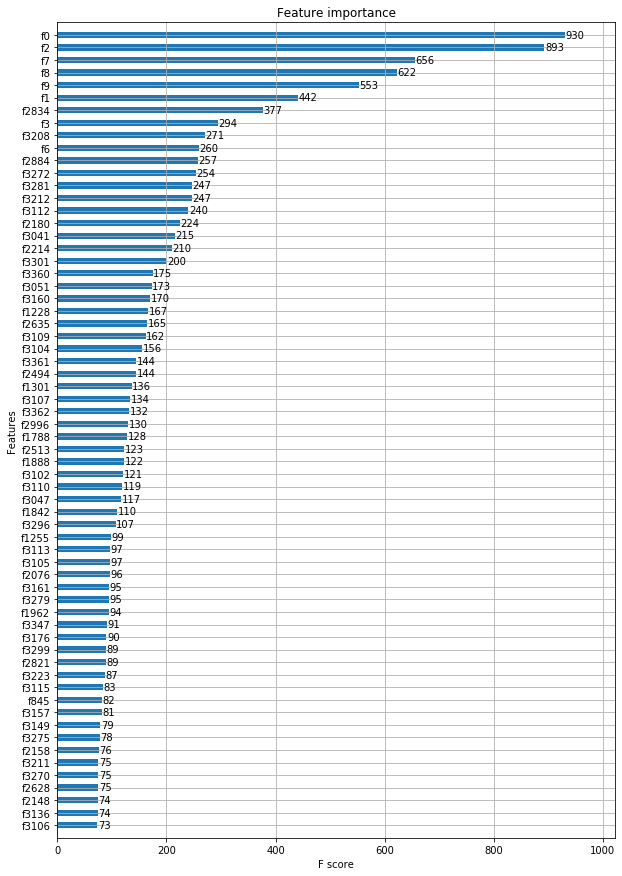

In [16]:
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(10,15))
plot_importance(clf,height=0.5,max_num_features=64,ax=ax)
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

number_of_runs = 20
optimization_output_path = "optimization_result.csv"

hyper_list = []                                                                 # The optimize parameters will be chosen from this list
n = 1
for i in range(number_of_runs):                                                 # 20 rounds of tunning
    print("Training model {} out of {}".format(n, number_of_runs))
    learning_rate = np.random.uniform(0.001, 0.15)                              # default size = 1
    max_depth = np.random.choice([3, 4, 5, 6])                                  # random sample from the given list
    n_estimators = np.random.randint(low=50, high=180)
    subsample = min(np.random.uniform(0.6, 1.1), 1.0)                           # lower value makes algorithm conservative
    colsample_bytree = min(np.random.uniform(0.6, 1.1), 1.0)

    params = {'learning_rate': learning_rate,                                   # Shrinkage used in update to prevent overfitting
              'max_depth': max_depth,
              'n_estimators': n_estimators,
              'subsample': subsample,                                           # Subsample ratio of the training instances
              'colsample_bytree': colsample_bytree}                             # The subsample ratio of columns when constructing each tree
    print(params)

    xgb_model = xgb.XGBClassifier(learning_rate=learning_rate,
                                 objective='binary:logistic',
                                 random_state=42,
                                 n_jobs=8,
                                 n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 subsample=subsample,
                                 colsample_bytree=colsample_bytree)

    xgb_model.fit(encoded, train['label'])
    
    preds = xgb_model.predict(X_test)
    print(preds)
    print(classification_report(test["label"], preds))
    acc = accuracy_score(test["label"], preds)
    params['acc'] = acc

    hyper_list.append(pd.DataFrame(params, index=[0]))
    n = n + 1
 
hyper_df = pd.concat(hyper_list)
hyper_df.sort_values('acc', inplace=True, ascending=False)                      # From larger one to smaller one
hyper_df.reset_index(drop=True, inplace=True)
hyper_df.to_csv(optimization_output_path)